# Importing libraries

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



#commom imports

import pathlib
current_path= (pathlib.Path().resolve())
import sys
import numpy as np
import pandas as pd
import random
import os
import tqdm
random.seed(42)
from datetime import datetime
from matplotlib import pyplot as plt
import math
import pickle
import torch
torch.manual_seed(42)
import torchvision.models
import torch.nn as nn
import torch.nn.functional as F


from pytorch_lightning import LightningModule, Trainer,seed_everything
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import Callback
from sklearn import preprocessing
from torch.autograd import grad
from base_lightning import Dataset

def gpu_prints():
    print("The total number of GPUs is:",torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("GPU number",i,"is",torch.cuda.get_device_name(i))
        
gpu_prints()


if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

#device will be cpu for now, changes are required to make code cuda compatible
#device="cpu"
print("Device is:",device)

#auxiliar functions

/tmp/ipykernel_191/3312626044.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The total number of GPUs is: 1
GPU number 0 is Quadro P5000
Device is: cuda


# Loading Original Data

## Loading Wind Speed Dataframe

In [3]:
df = pd.read_csv("/data/jose/final_speed_csv.csv", names=['Time1', 'Time2', 'Para', 'Alt',
                                          'Lon', 'Lat', 'Val'])

In [4]:
df.head()

,Time1,Time2,Para,Alt,Lon,Lat,Val
0,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.75,37.0,-8.0
1,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.50,37.0,-7.0
2,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.25,37.0,-6.0
3,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.00,37.0,-6.0
4,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-95.75,37.0,-6.0


In [6]:
df.Para.unique()

array(['UGRD', 'VGRD'], dtype=object)

In [7]:
def convert_2_hidx(row):
    dt = datetime.strptime(row['Time1'], "%Y-%m-%d %H:%M:%S")
    return dt.timestamp()/3600.0

df['Houridx'] = df.apply(convert_2_hidx, axis=1)
df.head()

,Time1,Time2,Para,Alt,Lon,Lat,Val,Houridx
0,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.75,37.0,-8.0,398974.0
1,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.50,37.0,-7.0,398974.0
2,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.25,37.0,-6.0,398974.0
3,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-96.00,37.0,-6.0,398974.0
4,2015-07-08 00:00:00,2015-07-08 06:00:00,UGRD,local level type 220 0,-95.75,37.0,-6.0,398974.0


In [9]:
uspeed_df = df[(df.Para.isin(["UGRD"])) & (df.Alt  == "100 m above ground")]
vspeed_df = df[(df.Para.isin(["VGRD"])) & (df.Alt  == "100 m above ground")]
vspeed_df.head()

,Time1,Time2,Para,Alt,Lon,Lat,Val,Houridx
18206,2015-07-08 00:00:00,2015-07-08 06:00:00,VGRD,100 m above ground,-97.00,37.0,-5.5,398974.0
18207,2015-07-08 00:00:00,2015-07-08 06:00:00,VGRD,100 m above ground,-96.75,37.0,-5.5,398974.0
18208,2015-07-08 00:00:00,2015-07-08 06:00:00,VGRD,100 m above ground,-96.50,37.0,-5.4,398974.0
18209,2015-07-08 00:00:00,2015-07-08 06:00:00,VGRD,100 m above ground,-96.25,37.0,-5.1,398974.0
18210,2015-07-08 00:00:00,2015-07-08 06:00:00,VGRD,100 m above ground,-96.00,37.0,-4.6,398974.0


In [10]:
#normalizing

uspeed_df.Val = (uspeed_df["Val"] - uspeed_df["Val"].mean()) / uspeed_df["Val"].std()
vspeed_df.Val = (vspeed_df["Val"] - vspeed_df["Val"].mean()) / vspeed_df["Val"].std()

uspeed_df.Lat = (uspeed_df["Lat"] - uspeed_df["Lat"].mean()) / uspeed_df["Lat"].std()
vspeed_df.Lat = (vspeed_df["Lat"] - vspeed_df["Lat"].mean()) / vspeed_df["Lat"].std()

uspeed_df.Lon = (uspeed_df["Lon"] - uspeed_df["Lon"].mean()) / uspeed_df["Lon"].std()
vspeed_df.Lon = (vspeed_df["Lon"] - vspeed_df["Lon"].mean()) / vspeed_df["Lon"].std()

initial_time = uspeed_df["Houridx"].iloc[0]
uspeed_df.Houridx -= initial_time
vspeed_df.Houridx -= initial_time
uspeed_df.Houridx /= 24
vspeed_df.Houridx /= 24

uspeed_df.Houridx = uspeed_df["Houridx"] - uspeed_df["Houridx"].mean() / uspeed_df["Houridx"].std()
vspeed_df.Houridx = vspeed_df["Houridx"] - vspeed_df["Houridx"].mean() / vspeed_df["Houridx"].std()



/home/jose/anaconda3/envs/DeepMod/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
temperature_df.shape == temporary_df.shape

True

In [30]:
uspeed_df.to_pickle('./UWindDataframe.pk.zip')
vspeed_df.to_pickle('./VWindDataframe.pk.zip')


In [ ]:
#normalizing the values

In [ ]:
v

In [12]:
df.Para.unique()

array(['UGRD'], dtype=object)

# Loading All Data

In [2]:
temperature_df = pd.read_pickle("./TransformedTemperatureDataframe.pk.zip")
v_speed_df     = pd.read_pickle("./VWindDataframe.pk.zip")
u_speed_df     = pd.read_pickle("./UWindDataframe.pk.zip")

In [3]:
print(temperature_df.describe())
print(u_speed_df.describe())
print(v_speed_df.describe())

                Lon           Lat           Val       Houridx
count  2.697526e+06  2.697526e+06  2.697526e+06  2.697526e+06
mean  -2.206020e-18 -2.107243e-20 -8.671600e-12  1.445892e-11
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.632993e+00 -1.632993e+00 -3.951368e+00 -1.731329e+00
25%   -8.164964e-01 -8.164964e-01 -7.313320e-01 -8.659276e-01
50%    0.000000e+00  0.000000e+00  1.058774e-01 -4.638731e-04
75%    8.164964e-01  8.164964e-01  8.142853e-01  8.654326e-01
max    1.632993e+00  1.632993e+00  2.433503e+00  1.733060e+00
                Lon           Lat           Val       Houridx
count  2.697526e+06  2.697526e+06  2.697526e+06  2.697526e+06
mean  -2.206020e-18 -2.107243e-20  4.420152e-16  4.278294e-12
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.632993e+00 -1.632993e+00 -5.673235e+00 -1.731329e+00
25%   -8.164964e-01 -8.164964e-01 -7.069938e-01 -8.659276e-01
50%    0.000000e+00  0.000000e+00 -1.301111e-02 -4.638731e-04
75%    8

# Creating input arrays to the model

In [4]:
#auxiliary variables
lon_list = temperature_df.Lon.unique()
lat_list = temperature_df.Lat.unique()
grid_size = len(lat_list) # squared grid!
total_grid_points     = grid_size**2

#temperature
temperature_array     = temperature_df["Val"].to_numpy()
temperature_tensor    = torch.tensor(temperature_array,dtype=torch.float32,device=device).view(-1,1)

#spatial coords, same for all the 3 DFs, I have checked it
lat_array  = temperature_df["Lat"].to_numpy()
lon_array  = temperature_df["Lon"].to_numpy()

lon_tensor = torch.tensor(lon_array,dtype=torch.float32,device=device).view(-1,1)
lat_tensor = torch.tensor(lat_array,dtype=torch.float32,device=device).view(-1,1)

#time, is the same for all the 3 DFs
time_array  = temperature_df["Houridx"].to_numpy()
time_tensor = torch.tensor(time_array,dtype=torch.float32,device=device).view(-1,1)
total_unique_time_points = int(len(time_array)/(grid_size**2))

#wind speed
uspeed_array  = u_speed_df["Val"].to_numpy()
uspeed_tensor = torch.tensor(uspeed_array,dtype=torch.float32,device=device).view(-1,1)

vspeed_array  = v_speed_df["Val"].to_numpy()
vspeed_tensor = torch.tensor(vspeed_array,dtype=torch.float32,device=device).view(-1,1)


#CNN arrays
aux_time_array        = []
[aux_time_array.append(t) for t in time_array[::total_grid_points]];
aux_temperature_array = np.zeros((len(aux_time_array),total_grid_points))
for j in np.arange(total_grid_points):
    aux = []
    for temp in temperature_array[j::total_grid_points]:
        aux.append(temp)
    aux_temperature_array[:,j] = aux

# each row is a 17,17 matrix, input to the CNNs!
#since I have 3 inputs I must have 2 matrices like this
temperature_fixed = np.zeros((total_unique_time_points,grid_size,grid_size))
v_speed_fixed     = np.zeros((total_unique_time_points,grid_size,grid_size))
u_speed_fixed     = np.zeros((total_unique_time_points,grid_size,grid_size))
aux1 = np.split(temperature_array,len(temperature_array)/17**2)
aux2 = np.split(uspeed_array,len(uspeed_array)/17**2)
aux3 = np.split(vspeed_array,len(vspeed_array)/17**2)


for index, (temp_grid,uspeed_grid,vspeed_grid) in enumerate(zip(aux1,aux2,aux3)):
    temp_aux = temp_grid.reshape(grid_size,grid_size)
    u_aux    = uspeed_grid.reshape(grid_size,grid_size)
    v_aux    = vspeed_grid.reshape(grid_size,grid_size)
    
    temperature_fixed[index,:,:] = temp_aux
    u_speed_fixed[index,:,:] = u_aux
    v_speed_fixed[index,:,:] = v_aux
    
    



In [5]:
temperature_fixed_tensor = torch.tensor(temperature_fixed,device=device,dtype=torch.float32)
uspeed_fixed_tensor      = torch.tensor(u_speed_fixed,device=device,dtype=torch.float32)
vspeed_fixed_tensor      = torch.tensor(v_speed_fixed,device=device,dtype=torch.float32)



X = torch.zeros((len(temperature_fixed),3,grid_size,grid_size),device=device,dtype=torch.float32)
X[:,0,:,:] = temperature_fixed_tensor
X[:,1,:,:] = uspeed_fixed_tensor
X[:,2,:,:] = vspeed_fixed_tensor
Y = temperature_fixed_tensor[1:,:,:]

#deltas as target and not real temps to make it easier to train
Diff_tensor = torch.diff(temperature_fixed_tensor,dim=0)
Y_diff = torch.clone(Diff_tensor)




#train/val split
split_percentage = 0.8
n_train = int(X.shape[0]*split_percentage)

#initial split
X_train,Y_train = torch.clone(X[:n_train,:,:,:]), torch.clone(Y[:n_train,:,:])
X_valid, Y_valid  = torch.clone(X[n_train:,:,:,:]), torch.clone(Y[n_train:,:,:])

#deltas split
Y_diff_train, Y_diff_valid = torch.clone(Y_diff[:n_train,:,:]), torch.clone(Y_diff[n_train:,:,:])


print(X_valid.shape)
print(Y_diff.shape)
print(Y_valid.shape)

torch.Size([1867, 3, 17, 17])
torch.Size([9333, 17, 17])
torch.Size([1866, 17, 17])


In [21]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
big = 18

plt.rc('font', size=big)          # controls default text sizes
plt.rc('axes', titlesize=big)     # fontsize of the axes title
plt.rc('axes', labelsize=big)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=big)    # fontsize of the tick labels
plt.rc('ytick', labelsize=big)    # fontsize of the tick labels
plt.rc('legend', fontsize=big)    # legend fontsize
plt.rc('figure', titlesize=big)  # fontsize of the figure title

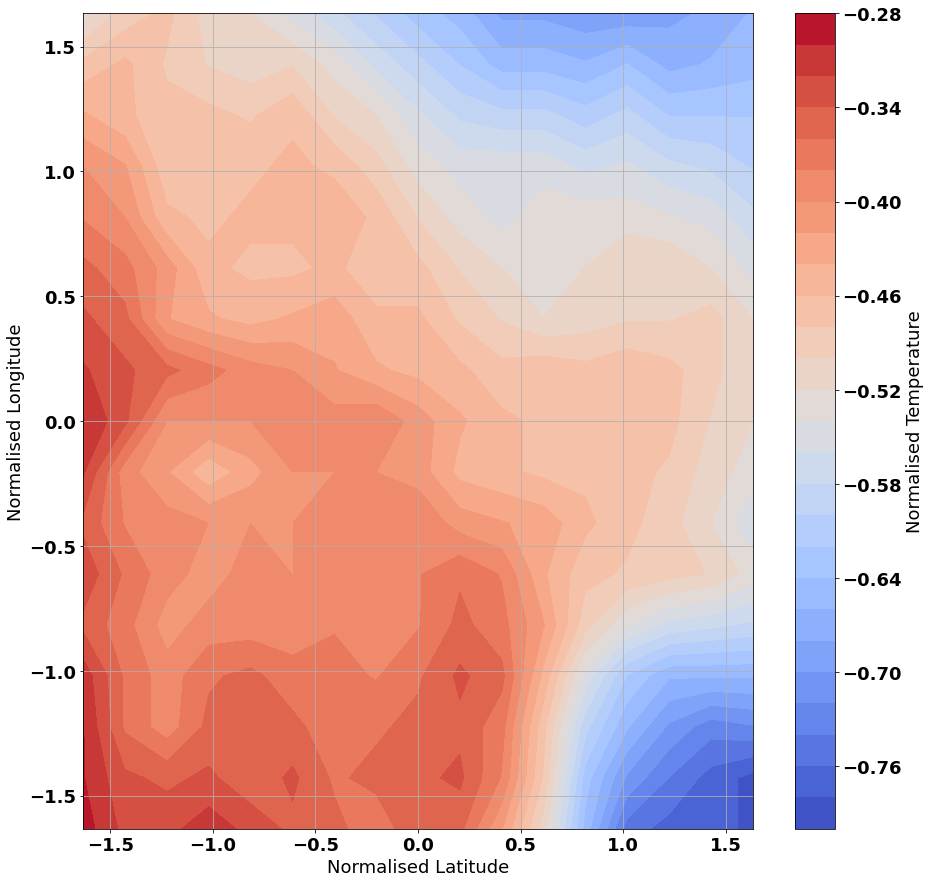

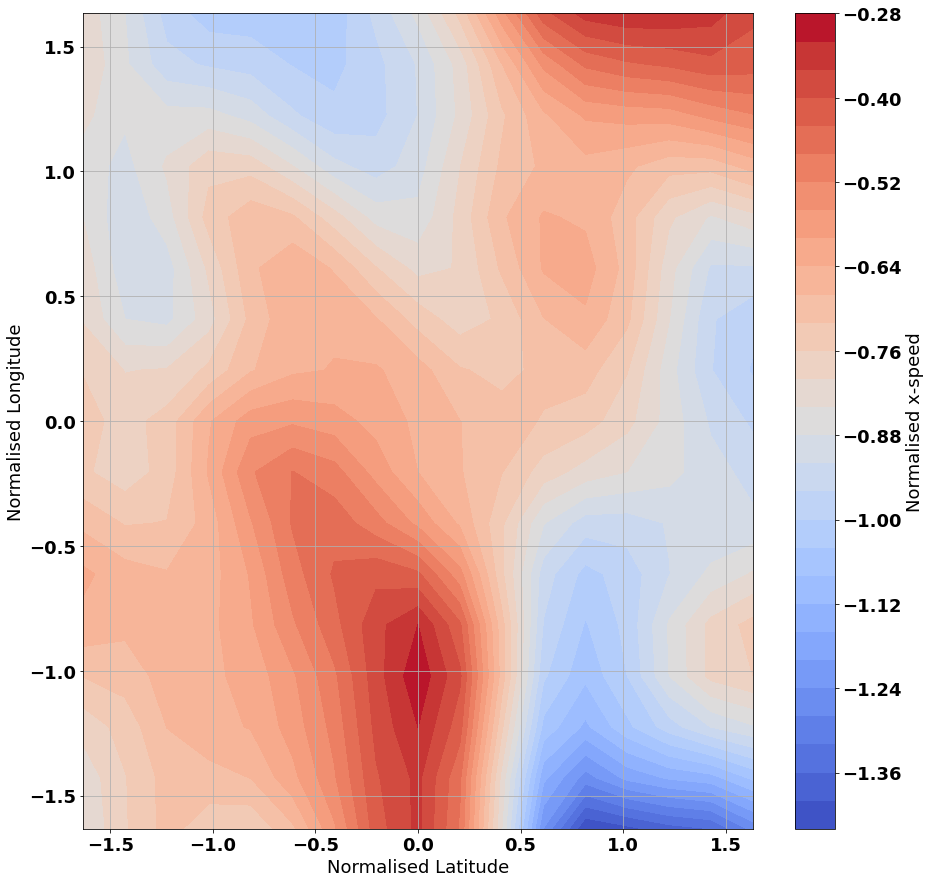

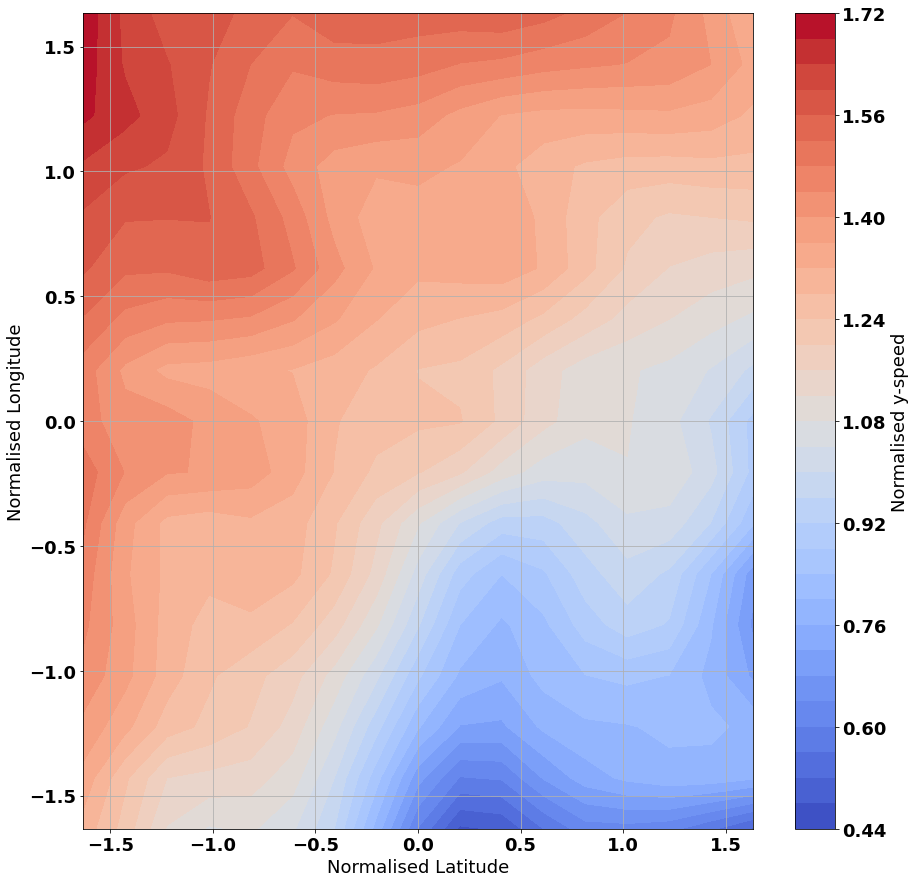

In [23]:
fig,axes = plt.subplots(ncols=1,figsize=(15,15))        
im0=axes.contourf(lat_list,lat_list,temperature_fixed[599,:,:],cmap="coolwarm",levels=30)
axes.set_xlabel('Normalised Latitude')
axes.set_ylabel('Normalised Longitude')
axes.grid()
fig.colorbar(im0, ax=axes,label="Normalised Temperature")
plt.savefig("temp2D.png",format="png",bbox_inches="tight")

plt.show()

fig2,axes2 = plt.subplots(ncols=1,figsize=(15,15))
im2 = axes2.contourf(lat_list, lat_list,u_speed_fixed[599,:,:], cmap='coolwarm',levels=30)
axes2.set_xlabel('Normalised Latitude')
axes2.set_ylabel('Normalised Longitude')
axes2.grid()
fig.colorbar(im2, ax=axes2,label="Normalised x-speed")
plt.savefig("u_speed.png",format="png",bbox_inches="tight")
plt.show()
        
fig3,axes3 = plt.subplots(ncols=1,figsize=(15,15))    
im3 = axes3.contourf(lat_list,lat_list,v_speed_fixed[599,:,:], cmap='coolwarm',levels=30)
axes3.set_xlabel('Normalised Latitude')
axes3.set_ylabel('Normalised Longitude')
axes3.grid()
fig3.colorbar(im3, ax=axes3, label="Normalised y-speed")
plt.savefig("v_speed.png",format="png",bbox_inches="tight")
plt.show()

# Baseline

In [8]:
def baseline_one(temperature_array_fixed):
    errors     = []
    mean_error = []
    temp_mean  = 13.399171592879668
    temp_std   = 10.86944374275543
    nr_points_per_day = 4 
    for t in range(4,temperature_array_fixed.shape[0]):
        past    = temperature_array_fixed[t-4,:,:]
        present = temperature_array_fixed[t,:,:]
        error    = np.mean((past-present)**2)
        mean_error.append(np.mean(np.abs(past-present)))
        errors.append(error)
    
    RMSE_error = np.mean(errors)
    print("Mean squared error is",RMSE_error)
    print("MAE is:",np.mean(mean_error))
    print("Mean squared error in degrees Celsius of baseline one is:",RMSE_error*temp_std)
    print("Mean error in degrees Celsius is:",np.sqrt(0.3*temp_std))
    #print("Mean error in degree Celsius is",np.mean(mean_error)*temp_std)
    return RMSE_error
baseline_one(temperature_fixed)    

Mean squared error is 0.17506697963894008
MAE is: 0.30404394542986757
Mean squared error in degrees Celsius of baseline one is: 1.9028806863995693
Mean error in degrees Celsius is: 1.805777705817255


0.17506697963894008

# CNN with 3 channels

In [5]:
class Convo(LightningModule):

    def __init__(self, X_train, Y_train, X_validation, Y_validation,batch_size_ratio,lr=1e-3):
        
        super().__init__()
        self.batch_size_ratio = batch_size_ratio
        self.learning_rate = lr
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_validation = X_validation
        self.Y_validation = Y_validation

        self.conv_layers = nn.Sequential(
                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding="same"),
                    nn.LeakyReLU(),
                    
                    
                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same"),
                    nn.LeakyReLU(),
            
                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding="same"),
                    nn.LeakyReLU(),
                    
                    
            
        )
                    
            
        self.linear_layers = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=9248,out_features=500),
            nn.LeakyReLU(),
            nn.Linear(in_features=500,out_features= 300),
            nn.LeakyReLU(),
            nn.Linear(in_features=300,out_features=17*17))
    

        self.conv_layers.apply(self.init_weights_linear)
        self.linear_layers.apply(self.init_weights_linear)
        

    def init_weights_linear(self,m):
        
        if type(m) == torch.nn.Linear:
            print(m)
            #torch.nn.init.kaiming_normal_(m.weight.data,nonlinearity="linear")
            nn.init.constant_(m.bias.data, 0.01)
            print(f'mean weight: {m.weight.data.mean()} and std weight: {m.weight.data.std()} ')
            print(f'mean bias:{m.bias.data.mean()} and std bias:{m.bias.data.std()}')
            print()
            
            
        elif type(m) == torch.nn.Conv2d:
            print(m)
            #print("setting convs")
            nn.init.kaiming_uniform_(m.weight.data,nonlinearity='leaky_relu')
            nn.init.constant_(m.bias.data, 0.01)
            
            print(f'mean weight: {m.weight.data.mean()} and std weight: {m.weight.std()} ')
            print(f'mean bias:{m.bias.data.mean()} and std bias:{m.bias.data.std()}')
            print()
    
    def get_histogram(self,x):
        
        fig = plt.figure(figsize=(16,6))
        plt.hist(x.detach().numpy().reshape(-1,1),bins=100)
        plt.title(f'Histogram at epoch nr{self.current_epoch} and at Conv1 layer')
        return fig
            
    def forward(self, x):

        x = self.conv_layers(x)
        x = self.linear_layers(x)
        
        return x
        
    
    
    def training_step(self, batch, batch_idx):
        
        x, target = batch
        prediction = self(x)
        prediction = prediction.reshape(-1,17,17)
        #prediction = torch.squeeze(prediction)
        loss = torch.mean((prediction - target) ** 2)
        self.log("Train Loss",loss, prog_bar=True, logger=True, on_epoch=True, on_step=False)
        
        return loss

    def validation_step(self,batch,batch_idx,dataloader_idx):
        
        x, target = batch
        prediction = self(x)
        prediction = torch.reshape(prediction,target.shape)
        val_loss = torch.mean((prediction-target)**2)
        prog_bar_list = [True, False, False, True, False, False, True, False, False, False, True, False]
        self.log(f"val_loss_{self.time_span[dataloader_idx]}", val_loss, on_epoch=True, logger=True,
                 prog_bar=prog_bar_list[dataloader_idx], on_step=False, add_dataloader_idx=False)
            
        #self.log("Val loss",val_loss, prog_bar=True, logger=True, on_epoch=True, on_step=False)

        

        return val_loss
 
    def configure_optimizers(self):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.90,
                                                                  #patience=50, threshold=0.08, threshold_mode="abs")
        
        return {"optimizer": optimizer}#,"lr_scheduler": lr_scheduler, "monitor": "Train Loss"}


    def train_dataloader(self):
        
        dataset = Dataset(data=self.X_train, labels=self.Y_train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(self.X_train) / self.batch_size_ratio),
                                                 drop_last=True, num_workers=0, shuffle=True)
        
        
        return dataloader

    
    def val_dataloader(self):
        
        self.time_span = [1, 2, 3, 7, 14, 21, 30, 60, 90, 120, 360,
                          int(len(self.X_validation) / (17 * 17))]  # nr of days in each validatio
        dataloader_list = []
        for j, i in enumerate(self.time_span):
            X_vali_aux, Y_vali_aux = torch.clone(self.X_validation[:int(25 * i), :]), torch.clone(
                self.Y_validation[:int(25 * i), :])
            val_dataset = Dataset(data=X_vali_aux, labels=Y_vali_aux)
            dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=int(len(X_vali_aux)), num_workers=0)
            dataloader_list.append(dataloader)
        
        
        #dataset = Dataset(data=self.X_validation, labels=self.Y_validation)
        #dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(self.X_validation), num_workers=0)
                                                 
        #print("valid dataloader has shape",len(dataloader))
        return dataloader_list
    
    def custom_histogram_adder(self):
        
        if self.logger == "TensorBoard":
            #iterating through all parameters
            for name, params in self.named_parameters():
                self.logger.experiment.add_histogram(name, params, self.current_epoch)

In [ ]:
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint


neptune_logger = NeptuneLogger(api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZjZhNTE2Ni04MDkwLTRkYjAtYjNmOS0wYTNiMDZmMWJkNDkifQ==",project="jose.bastos/CNN")

checkpoint_callback = ModelCheckpoint(dirpath=f"{current_path}/models/CNN/")
#logger = TensorBoardLogger("tb_logs", name="test")


model  = Convo(X_train=X_train,
               X_validation=X_valid,
              Y_train = Y_diff_train,
              Y_validation = Y_diff_valid,
              batch_size_ratio =400,
               lr=3e-4)




print(model)

lr_monitor = LearningRateMonitor(logging_interval='epoch')


kwargs  = {"max_epochs":500,
               "gpus": 1,
               "progress_bar_refresh_rate":10,
               "num_sanity_val_steps":0,
               "logger" : neptune_logger,
               "enable_checkpointing": False,
               "callbacks":[lr_monitor]}

trainer = Trainer(**kwargs)

trainer.fit(model)
neptune_logger.experiment.stop()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type       | Params
---------------------------------------------
0 | conv_layers   | Sequential | 14.2 K
1 | linear_layers | Sequential | 4.9 M 
---------------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.504    Total estimated model params size (MB)


Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
mean weight: 0.006141769699752331 and std weight: 0.2848585546016693 
mean bias:0.009999998845160007 and std bias:9.956256930010454e-10

Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
mean weight: -0.008233118802309036 and std weight: 0.16446469724178314 
mean bias:0.009999998845160007 and std bias:9.618658092236387e-10

Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
mean weight: 0.0005536038661375642 and std weight: 0.07123788446187973 
mean bias:0.009999998845160007 and std bias:9.462246541858121e-10

Linear(in_features=9248, out_features=500, bias=True)
mean weight: -1.928662413774873e-06 and std weight: 0.006003434769809246 
mean bias:0.009999998845160007 and std bias:9.322552729784661e-10

Linear(in_features=500, out_features=300, bias=True)
mean weight: -3.737475708476268e-05 and std weight: 0.025882959365844727 
mean bias:0.009999997913837433 and std bias:1.8657573264135863e-09

Linear

Training: 0it [00:00, ?it/s]

https://app.neptune.ai/jose.bastos/CNN/e/CNN-339
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [18]:
def Cnn_Plot(model,dataframe,number_of_time_steps,X,Y):
    
    #takes input the model,dataframe and number of time steps and plots the model's prediction against the real values
    X = X.to("cpu")
    grid_size = 17
    lat_list = np.arange(37,41.25,0.25,dtype=np.float32)
    
    split_percentage = 0.8
    n_train = int(X.shape[0]*split_percentage)
                   
        
    
    model_output       = model.forward(X).detach().numpy()
    model_output       = model_output.reshape(-1,17,17)
    time_samples       = random.sample(range(n_train,X.shape[0]-1),number_of_time_steps)
    #time_samples = [0,1000,2000,8000,9000]
    
    for time_step in time_samples:
        
        pred_temp      = model_output[time_step,:,:]
        real_temp = Y[time_step,:,:].detach().cpu().numpy()
        dif = np.abs((real_temp-pred_temp)/(real_temp+1e-8)*100)
                
        combined_data  = np.concatenate((pred_temp,real_temp))
        _min, _max     = np.amin(combined_data), np.amax(combined_data)
        
        
        mean_error = np.mean((pred_temp-real_temp)**2)
        
        
        fig,axes = plt.subplots(ncols=3,figsize=(30,6))
        fig.suptitle(f"Temperature at time step {time_step}")
        levels = np.arange(_min,_max+0.2,0.05)
        
        im0=axes[0].contourf(lat_list,lat_list,pred_temp.transpose(),cmap="coolwarm",vmin=_min,vmax=_max,levels =levels)
        axes[0].set_xlabel('Latitude')
        axes[0].set_ylabel('Longitude')
        axes[0].set_title('Model prediction')
        axes[0].grid()
        fig.colorbar(im0, ax=axes[0])

        
        im1 = axes[1].contourf(lat_list, lat_list,real_temp.transpose(), cmap='coolwarm',vmin=_min, vmax=_max,levels= levels)
        axes[1].set_xlabel('Latitude')
        axes[1].set_ylabel("Longitude")
        axes[1].set_title('Real Data')
        axes[1].grid()
        fig.colorbar(im1, ax=axes[1])
        
        im2 = axes[2].contourf(lat_list, lat_list,dif.transpose(), cmap='plasma',levels=30)
        axes[2].set_xlabel('Latitude')
        axes[2].set_ylabel("Longitude")
        axes[2].set_title('Relative  difference from the predicted temp to the real')
        axes[2].grid()
        fig.colorbar(im2, ax=axes[2])
        
        
        
        print(" Mean Squared error is:",mean_error)
        
        plt.show()

 Mean Squared error is: 0.029494474


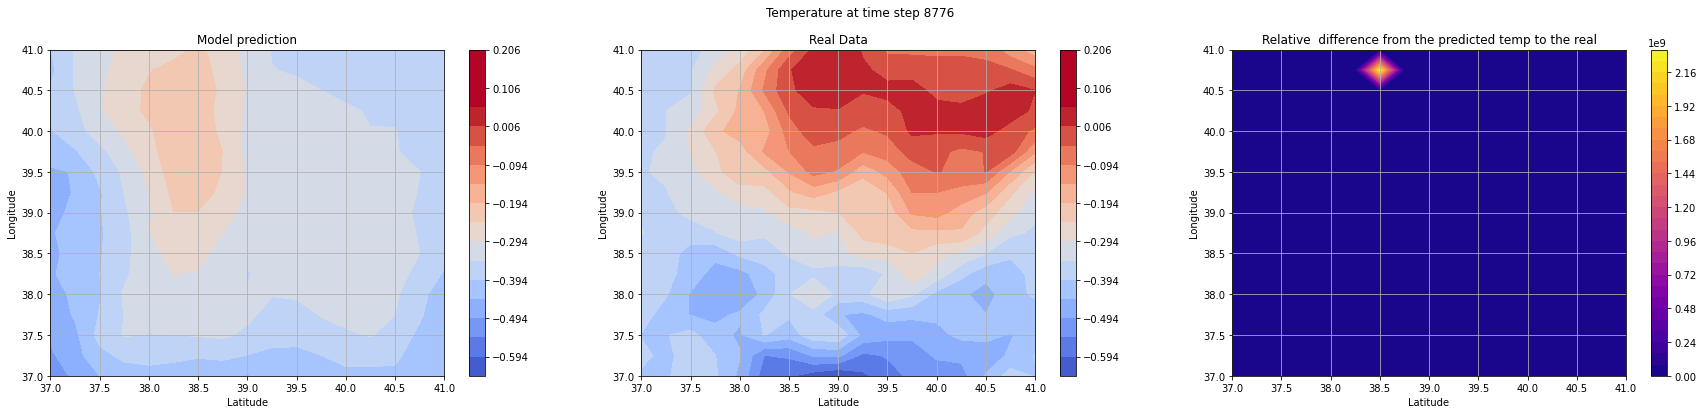

 Mean Squared error is: 0.031399827


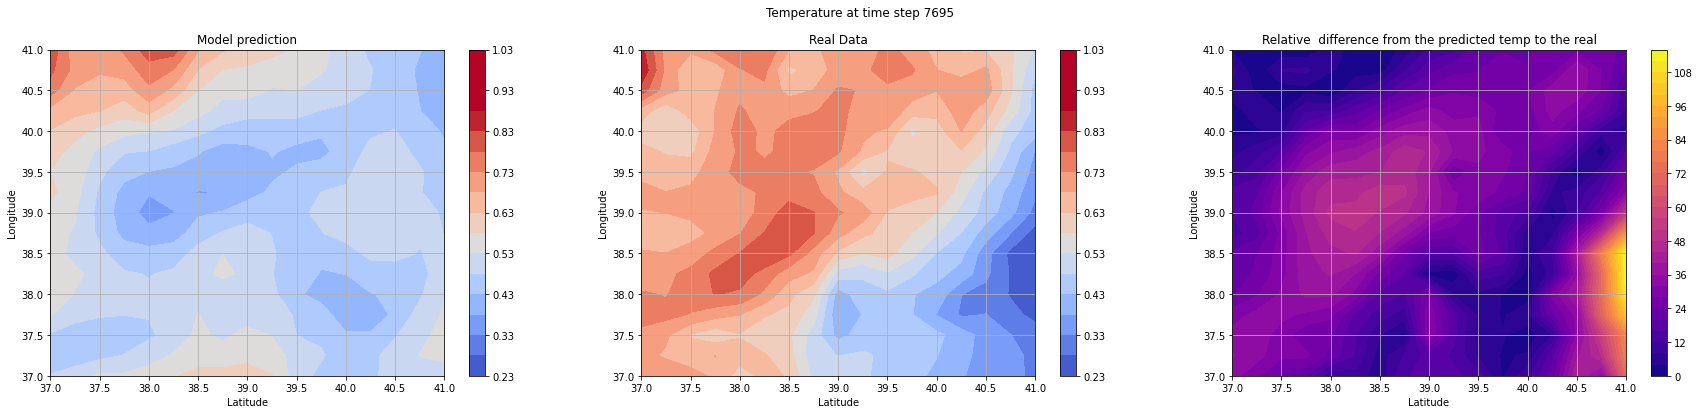

 Mean Squared error is: 0.010271668


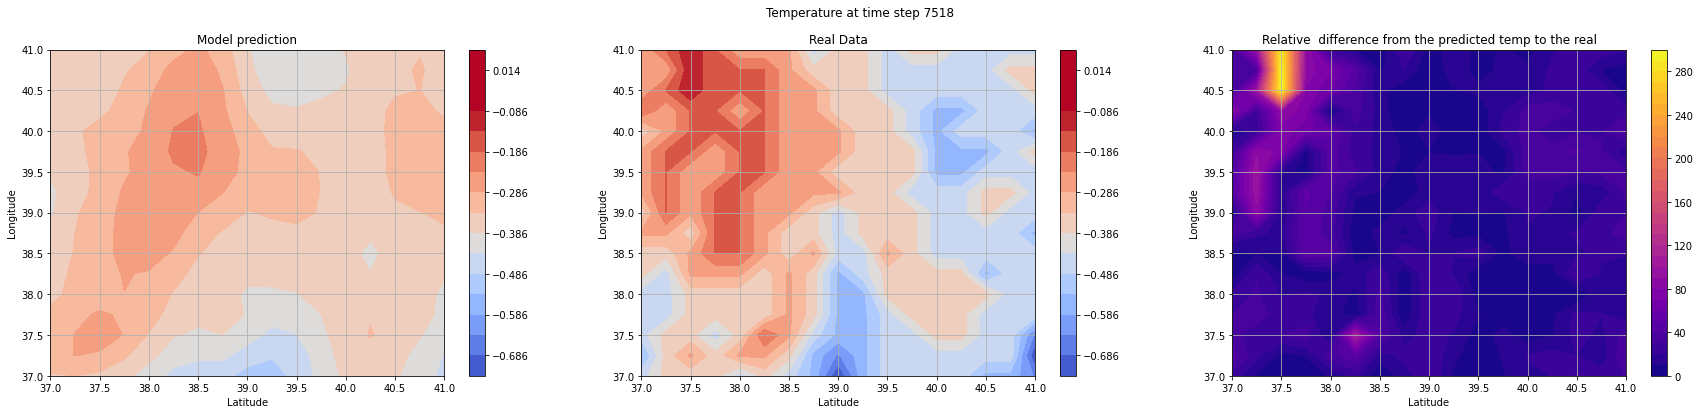

 Mean Squared error is: 0.014123408


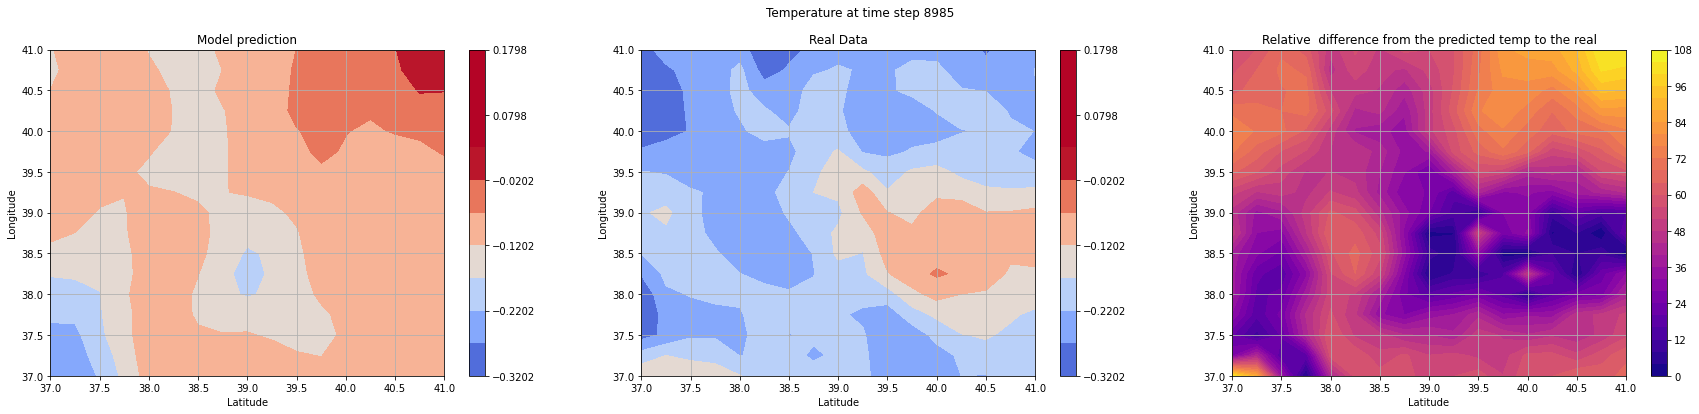

 Mean Squared error is: 0.008031831


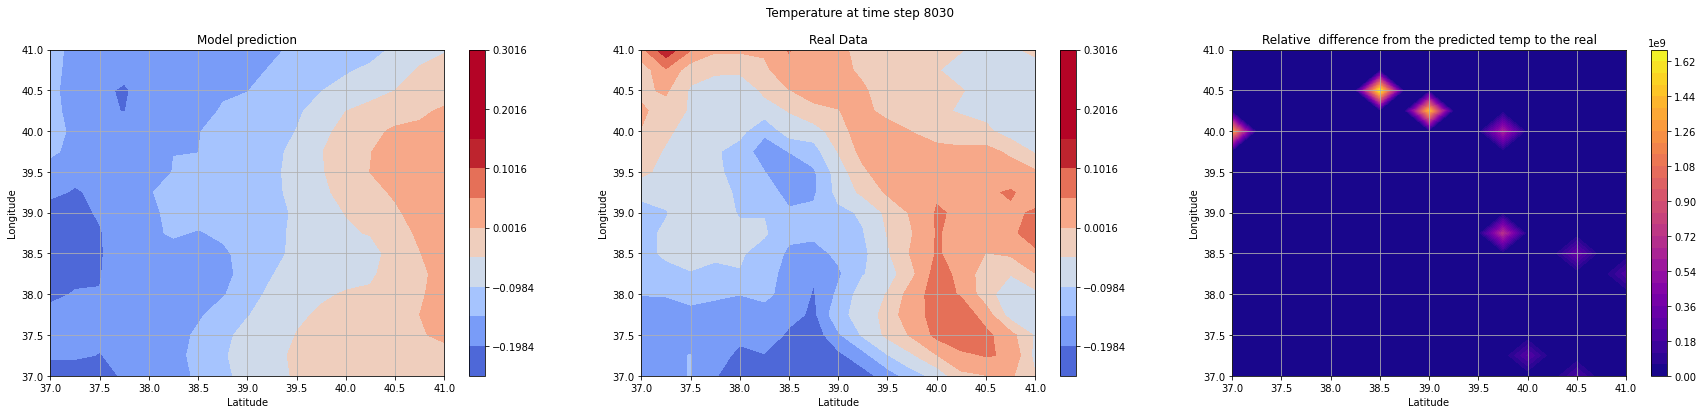

 Mean Squared error is: 0.0092575485


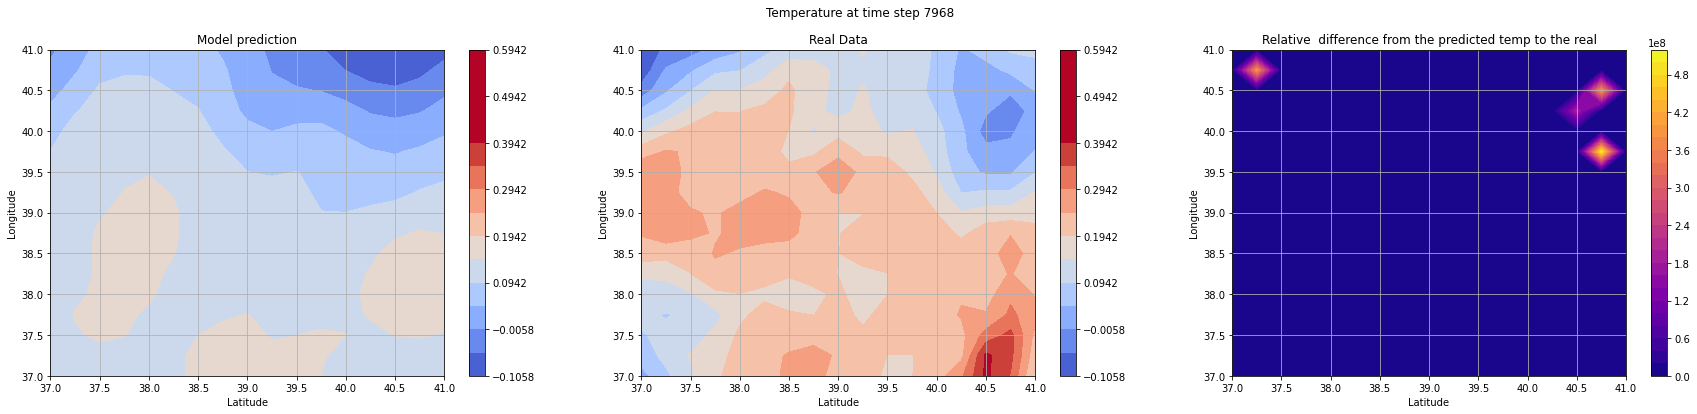

 Mean Squared error is: 0.013738089


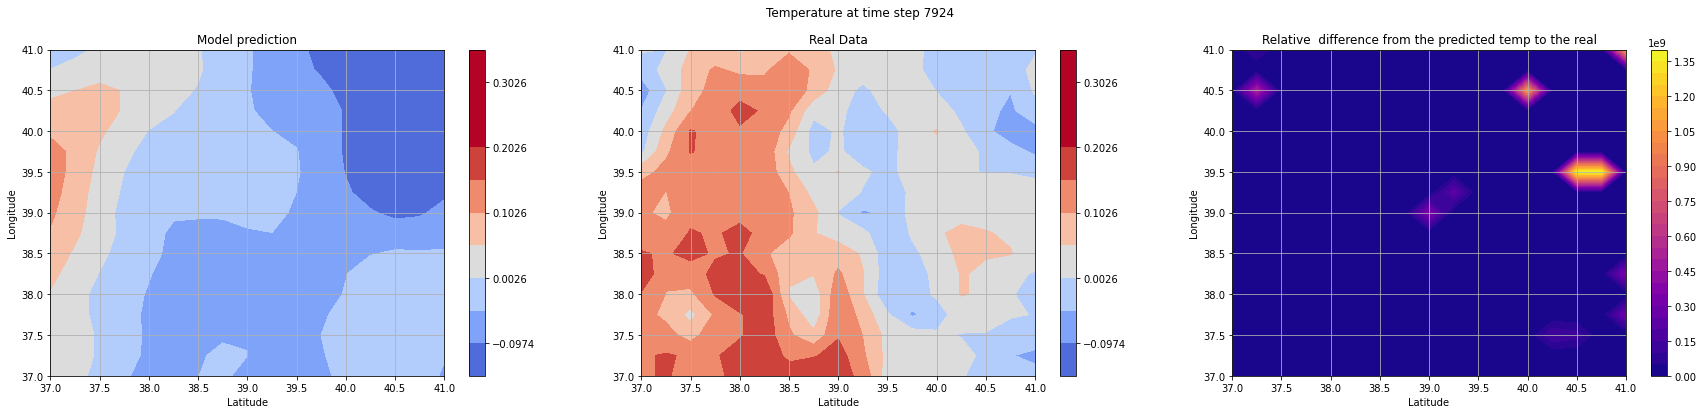

 Mean Squared error is: 0.040297106


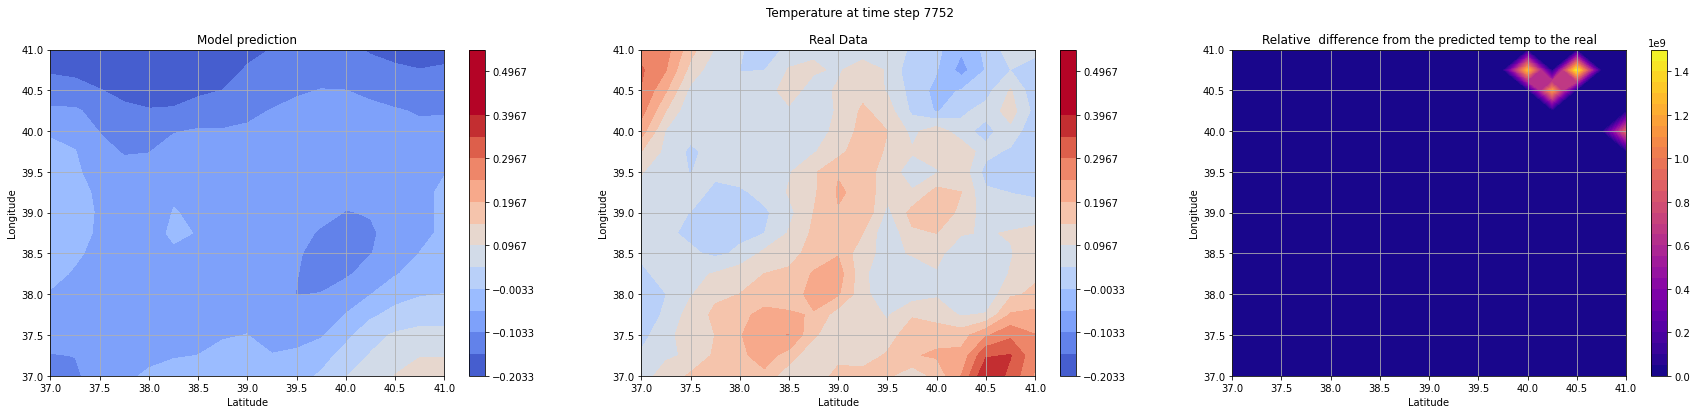

 Mean Squared error is: 0.028259676


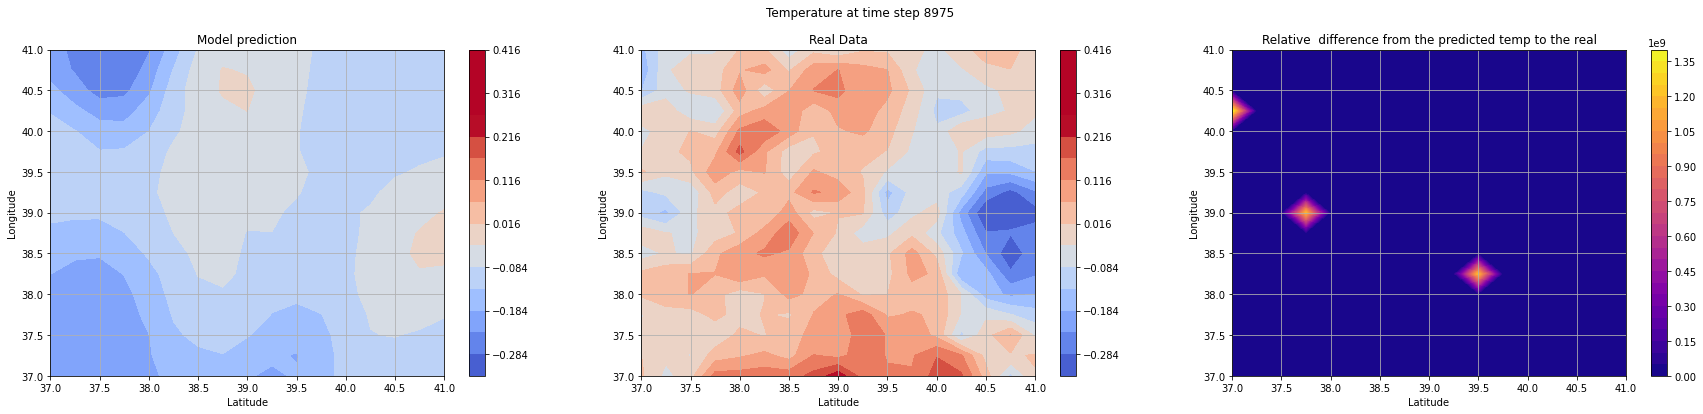

 Mean Squared error is: 0.01877254


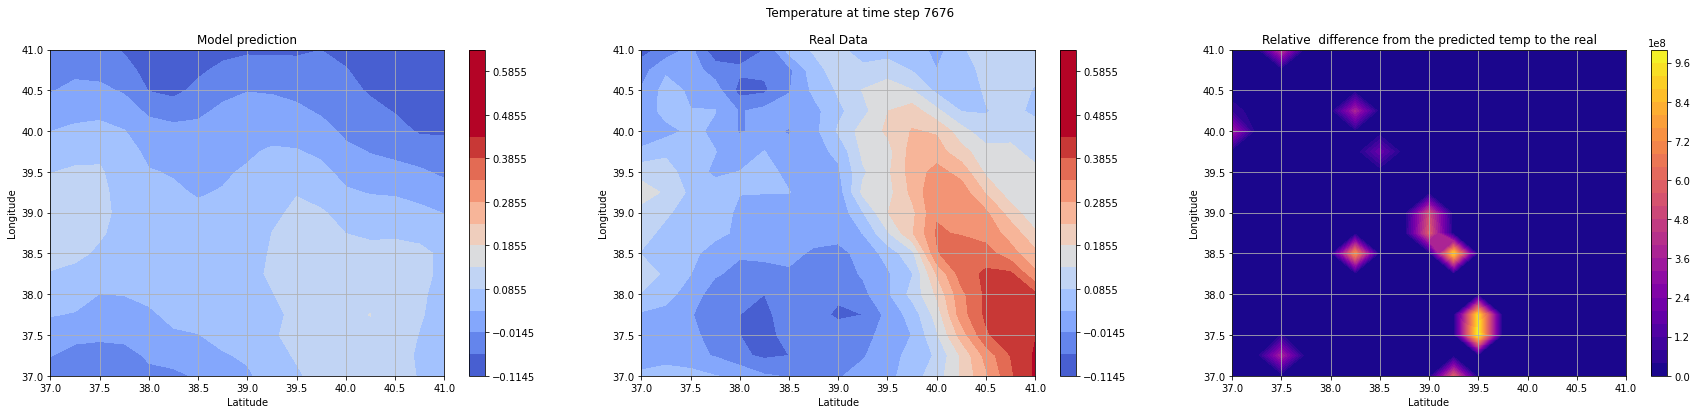

In [19]:
Cnn_Plot(model,temperature_df,10,X,Y_diff)